In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# Use the observed clustering of points

The chicago data is already very strongly clustered along street segments, so instead of using a street network, we perhaps can work directly with the points from the input data.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import geopandas as gpd
import numpy as np
import tilemapbase
import shapely.geometry
import descartes
import lzma, collections

import opencrimedata.chicago
import opencrimedata.voroni
import opencrimedata.geometry
import opencrimedata.replace

import open_cp.geometry
open_cp.geometry.configure_gdal()
import open_cp.logger
open_cp.logger.log_to_true_stdout("opencrimedata")
import pyproj
proj = pyproj.Proj({"init":"epsg:2790"})

## Load input data

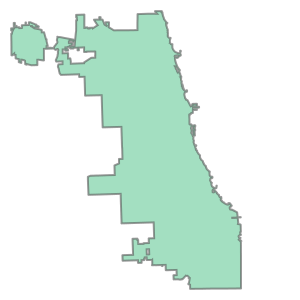

In [3]:
#datadir = os.path.join("/media", "disk", "Data")
datadir = os.path.join("..", "..", "..", "..", "Data")
g = gpd.GeoDataFrame.from_file(os.path.join(datadir, "Chicago_Areas.geojson"))
g.crs = {'init': 'epsg:4326'}
g = g.to_crs({"init":"epsg:2790"}).geometry
chicago = g.unary_union.buffer(15)
chicago

In [4]:
filename = os.path.join(datadir, "chicago_all.csv.xz")

def gen():
    with lzma.open(filename, "rt", encoding="utf8") as f:
        yield from opencrimedata.chicago.load_only_with_point(f)
        
points = np.asarray([row.point for row in gen() if row.datetime.year > 2001])
points = np.asarray(list(proj(*points.T))).T
points.shape

(5840574, 2)

In [5]:
ag = opencrimedata.geometry.AggregatePointsViaGraph(points, tolerance=10)

In [6]:
uniques_points_counts = collections.defaultdict(int)
for x,y in points:
    uniques_points_counts[(x,y)] += 1
unique_points = np.asarray(list(uniques_points_counts))
unique_points.shape

(629625, 2)

In [7]:
sections = collections.defaultdict(set)

for i, pt in enumerate(unique_points):
    sections[ ag.index(pt) ].add(i)
    
sections = list(sections.values())

In [8]:
# Add circle around
circle = np.asarray(list(chicago.buffer(10000).exterior.coords))
sections.append({unique_points.shape[0]+i for i in range(circle.shape[0])})
unique_points = np.vstack([unique_points, circle])

In [9]:
voroni = opencrimedata.voroni.VoroniMergedCells(unique_points, sections)

In [10]:
polygons = list(voroni.all_polygons_clipped(chicago.buffer(10)))

### Now merge these "selectively"

Let's try merging further.  Look at cells:
- Which touch each other
- Are small
- Contain a small number of points (this should be "total crime events" not "unique point count").
- Have some overlap in assigned "BLOCK"

In [11]:
# Lookup from point to block name
blocks = collections.defaultdict(set)
def gen1():
    for row in gen():
        if row.datetime.year > 2001:
            yield row

for pt, row in zip(points, gen1()):
    np.testing.assert_allclose(pt, proj(*row.point))
    blocks[tuple(pt)].add(row.address)

In [12]:
def points_in_polygon(poly, points):
    xmin, ymin, xmax, ymax = poly.bounds
    pts = points[np.all((points >= [xmin, ymin]) & (points <= [xmax, ymax]), axis=1), :]
    pts = shapely.geometry.MultiPoint(pts).intersection(poly)
    pts = np.asarray(pts)
    if len(pts.shape) == 1:
        pts = pts[None,:]
    return pts

def blocks_for_polygon(poly, points, blocks):
    """Return a set of the block names for which there is a point in the polygon."""
    pts = points_in_polygon(poly, points)
    out = set()
    for pt in pts:
        out.update(blocks[tuple(pt)])
    return out

def count_points_in_polygon(poly, points):
    return points_in_polygon(poly, points).shape[0]

In [13]:
# Polygons which are small and contain "few" events
mergeable_polygons = []
for poly in polygons:
    if poly.is_empty:
        mergeable_polygons.append(False)
        continue
    count = count_points_in_polygon(poly, points)
    area = poly.area
    if count < 30 and area < 100*100:
        mergeable_polygons.append(True)
    else:
        mergeable_polygons.append(False)
        
mergeable_polygon_indices = [i for i, want in enumerate(mergeable_polygons) if want]

In [14]:
blocks_from_polygons = []
for i in mergeable_polygon_indices:
    p = polygons[i]
    b = blocks_for_polygon(p, points, blocks)
    blocks_from_polygons.append(b)

In [15]:
builder = open_cp.network.GraphBuilder()
for idx, i in enumerate(mergeable_polygon_indices):
    p1 = polygons[i]
    b1 = blocks_from_polygons[idx]
    for idx1 in range(idx+1, len(mergeable_polygon_indices)):
        j = mergeable_polygon_indices[idx1]
        p2 = polygons[j]
        b2 = blocks_from_polygons[idx1]
        if len(b1 & b2) > 0 and p1.intersects(p2):
            builder.add_edge(i, j)

In [16]:
graph = builder.build()

In [17]:
final_merged_polygons = []
used_indicies = set()
for c in open_cp.network.connected_components(graph):
    c = list(c)
    p = polygons[c[0]]
    for i in c[1:]:
        pp = polygons[i]
        p = p.union(pp)
    used_indicies.update(c)
    final_merged_polygons.append(p)
    
for i, p in enumerate(polygons):
    if i not in used_indicies:
        final_merged_polygons.append(p)
        
final_merged_polygons = [p for p in final_merged_polygons if not p.is_empty]

## Some plots

In [26]:
def project_polygon(p):
    if p.geometryType() == "Polygon":
        poly = []
        for x, y in zip(*proj(*np.asarray(p.exterior).T, inverse=True)):
            poly.append(tilemapbase.project(x, y))
        return shapely.geometry.Polygon(poly)
    else:
        return shapely.geometry.MultiPolygon([project_polygon(pp) for pp in p])
    
def draw(lon, lat, polys, xsize=0.0001, ax=None):
    ex = tilemapbase.Extent.from_centre_lonlat(lon, lat, xsize)
    plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    else:
        fig = None
    plotter.plot(ax, alpha=0.8)

    pp = [descartes.PolygonPatch(project_polygon(p)) for p in polys if not p.is_empty]
    #pp = matplotlib.collections.PatchCollection(pp, color="red", alpha=0.3)
    pp = matplotlib.collections.PatchCollection(pp, facecolor="none", edgecolor="black")
    ax.add_collection(pp)
    
    return fig

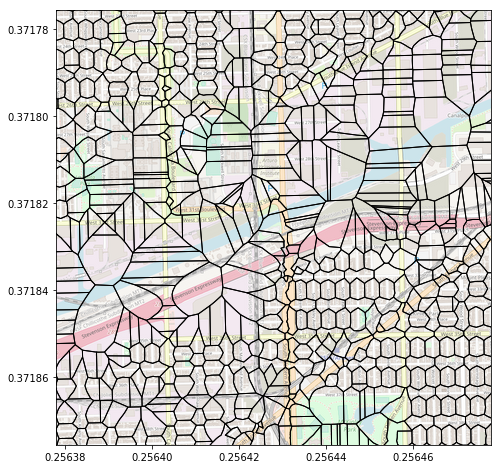

In [19]:
fig = draw(-87.686, 41.837, final_merged_polygons)

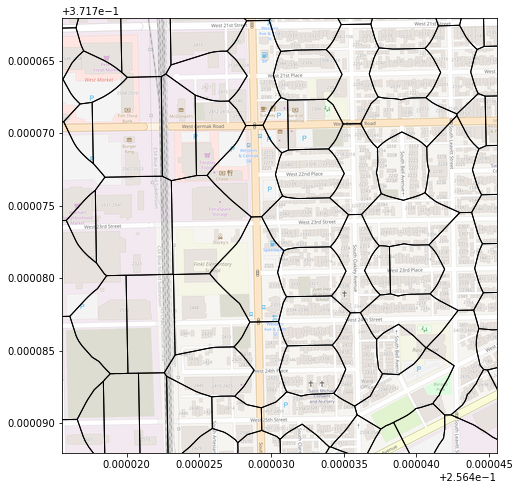

In [20]:
fig = draw(-87.685, 41.85, final_merged_polygons, 0.00003)

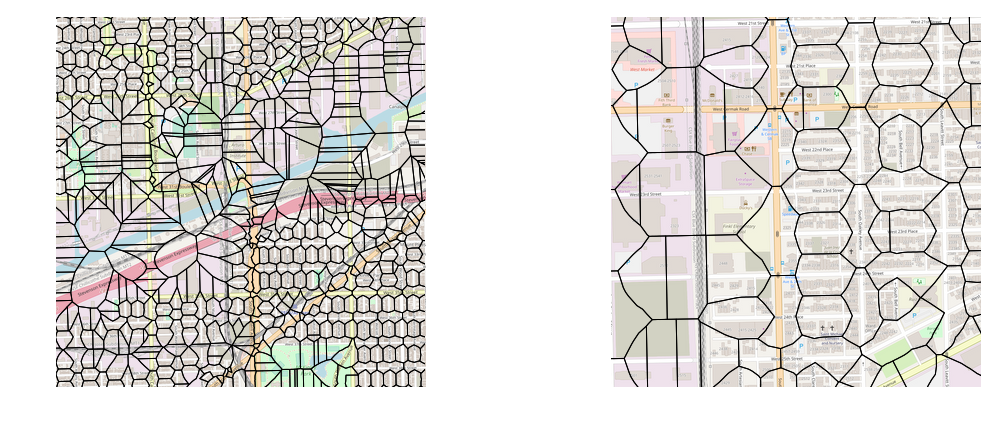

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

draw(-87.686, 41.837, final_merged_polygons, ax=axes[0])
draw(-87.685, 41.85, final_merged_polygons, 0.00003, ax=axes[1])
for ax in axes:
    ax.set_axis_off()
fig.tight_layout()

In [28]:
fig.savefig("chiago_voroni_clustering_polys.png", dpi=150)

# Do a redistribution

In [25]:
def gen():
    with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as f:
        yield from opencrimedata.chicago.load_only_with_point(f)

next(gen())

Row(id='5189091', crime_type='OFFENSE INVOLVING CHILDREN', crime_subtype='CHILD ABUSE', location='RESIDENCE', address='108XX S AVENUE G', datetime=datetime.datetime(2006, 10, 12, 10, 58), point=(-87.531655723, 41.698387427))

In [26]:
credist = opencrimedata.geometry.CachingRedistributor(final_merged_polygons)

In [27]:
class AssignNew(opencrimedata.replace.AssignNew):
    def adjust(self, row):
        pt = credist.redistribute_within_radius(*proj(*row.point), 100)
        if pt is None:
            return None
        return opencrimedata.chicago.row_with_new_position(row, *proj(*pt, inverse=True))

In [28]:
assign = AssignNew(gen(), seed=1234)
with lzma.open(os.path.join(datadir, "chicago_redist_cluster.csv.xz"), "wt", newline="") as f:
    opencrimedata.chicago.write(f, assign)

### Hashes

- Input: `dc1026949999aaccbf6333db953e59decc39906f21908fdda54285ef7dac6e9c`
- Output:
  - PC: `3ac601caa7dd90607685b9529c110c355f1126bc223dcbd6023a884383a79a07`
- Counts: (6323451, 102)

In [29]:
assign.input_hash

'dc1026949999aaccbf6333db953e59decc39906f21908fdda54285ef7dac6e9c'

In [30]:
assign.output_hash

'3ac601caa7dd90607685b9529c110c355f1126bc223dcbd6023a884383a79a07'

In [31]:
assign.input_size, assign.failed_to_reassign_count

(6323451, 102)

# Plot

In [32]:
def gen_new():
    filename = os.path.join(datadir, "chicago_redist_cluster.csv.xz")
    with lzma.open(filename, "rt", encoding="utf8") as f:
        yield from opencrimedata.chicago.load_only_with_point(f)

In [34]:
new_pts = {int(r.id) : r.point for r in gen_new()}
old_pts = {int(r.id) : r.point for r in gen()}

In [37]:
for x in new_pts:
    assert x in old_pts
    
new_pts_wm, old_pts_wm = [], []
for key in new_pts:
    new_pts_wm.append(tilemapbase.project(*new_pts[key]))
    old_pts_wm.append(tilemapbase.project(*old_pts[key]))
new_pts_wm = np.asarray(new_pts_wm)
old_pts_wm = np.asarray(old_pts_wm)

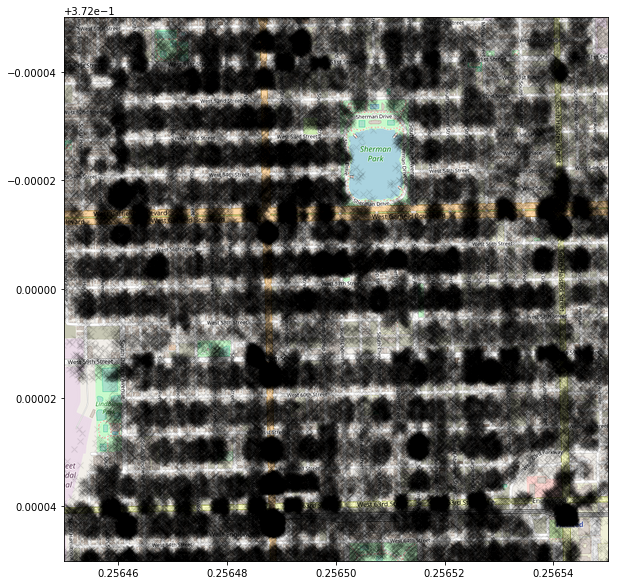

In [38]:
x, y = 0.2565, 0.372
ex = tilemapbase.Extent.from_centre(x, y, xsize=0.0001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

fig, ax = plt.subplots(figsize=(10,10))
plotter.plot(ax)
ax.scatter(*new_pts_wm.T, marker="x", color="black", linewidth=1, alpha=0.1)

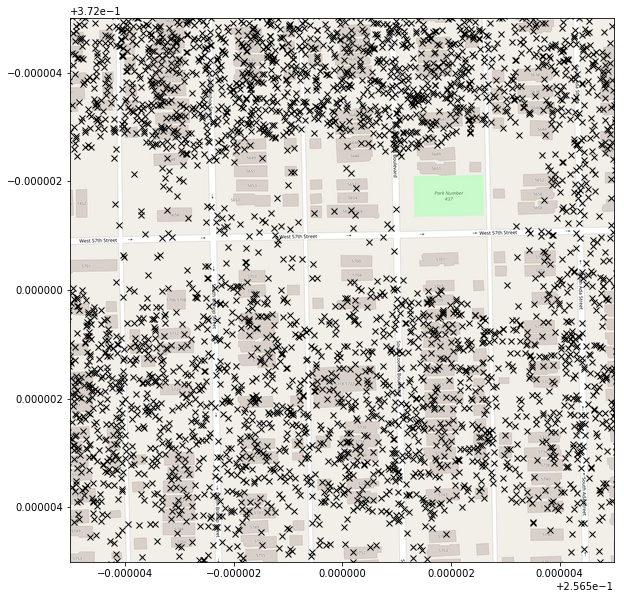

In [40]:
x, y = 0.2565, 0.372
ex = tilemapbase.Extent.from_centre(x, y, xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

fig, ax = plt.subplots(figsize=(10,10))
plotter.plot(ax)
ax.scatter(*new_pts_wm.T, marker="x", color="black", linewidth=1, alpha=1)
None

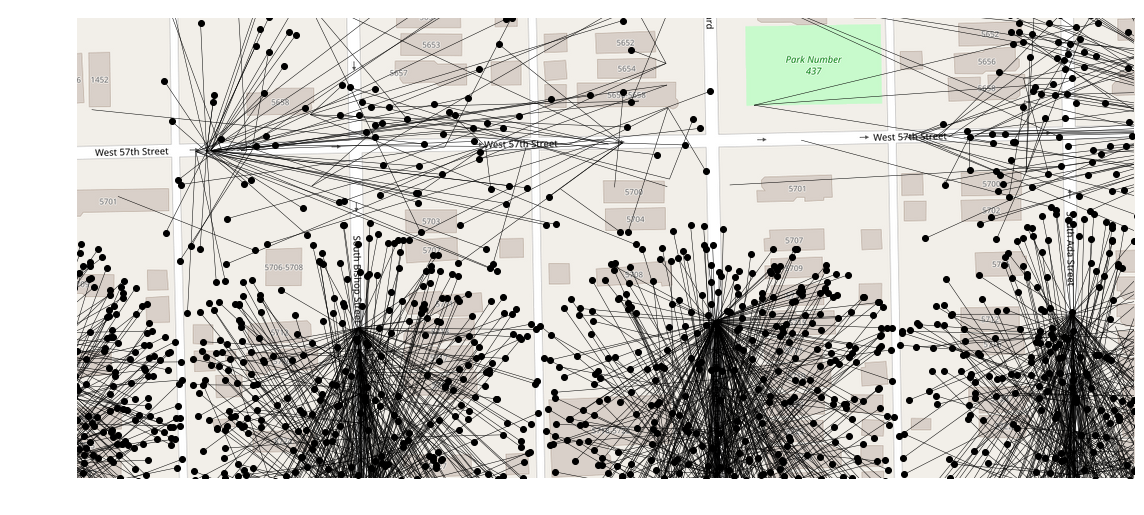

In [42]:
x, y = 0.2565, 0.372
ex = tilemapbase.Extent.from_centre(x, y, xsize=0.00001, aspect=2.3)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

fig, ax = plt.subplots(figsize=(16,8))
plotter.plot(ax)
#ax.scatter(*old_wm_pts.T, marker="x", color="black", linewidth=1, alpha=1)
ax.scatter(*new_pts_wm.T, marker="o", color="black", linewidth=1, alpha=1)

lines = []
for x,y,xx,yy in zip(*new_pts_wm.T, *old_pts_wm.T):
    lines.append(((x,y), (xx,yy)))
ax.add_collection(matplotlib.collections.LineCollection(lines, color="black", linewidth=0.5))
ax.set_axis_off()
fig.tight_layout()

In [43]:
fig.savefig("chicago_redist_cluster.png", dpi=100)